In [1]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn import decomposition
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg, rand_string
from disp import set_plot, plot_b, trj_3d

from record_0_main import smlt_ma

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

FSTRAIN = 'data/simple/strains.csv'
MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

Load behavioral data from Coen et al 2014

In [2]:
df_behav = pd.read_csv('data/simple/c_song_f_behav.csv')
df_behav

,ID,FRAME,T,Q,S,P,F,FFV,FFA,FLS,FRS,FMFV,FMLS
0,0,0,0.000000,1,0,0,0,0.231,0.0000,0.159,0.077,-0.058526,0.274257
1,0,1,0.033300,1,0,0,0,0.314,0.0385,0.025,0.044,0.100623,0.298490
2,0,2,0.066600,1,0,0,0,0.308,0.0025,0.029,0.011,0.147629,0.271865
3,0,3,0.099900,1,0,0,0,0.319,0.0020,0.016,0.016,0.091174,0.306112
4,0,4,0.133200,1,0,0,0,0.312,-0.0315,0.030,0.002,0.065871,0.306439
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4978565,275,27100,902.430902,1,0,0,0,0.217,0.0280,0.029,0.058,-0.171418,0.136184
4978566,275,27101,902.464202,1,0,0,0,0.210,-0.1045,0.138,0.322,0.032522,0.249171
4978567,275,27102,902.497502,1,0,0,0,0.008,-0.0910,0.034,0.260,0.033202,0.010844
4978568,275,27103,902.530803,1,0,0,0,0.028,0.0695,0.010,0.090,0.012059,0.027177


In [3]:
# split big df into dfs for individual trials
n_tr = np.max(df_behav.ID) + 1
df_trs = [df_behav[df_behav.ID == i] for i in ISTRAIN]

df_behav = None

In [4]:
N = 10

rtau_r = [20, 60]
rtau_a = [.1, 2]

tau_rs = np.random.uniform(*rtau_r, N)
tau_as = np.random.uniform(*rtau_a, N)
x_ss = np.random.uniform(0, 1, N)
x_ps = 1 - x_ss

params = {'TAU_R': tau_rs, 'TAU_A': tau_as, 'X_S': x_ss, 'X_P': x_ps}

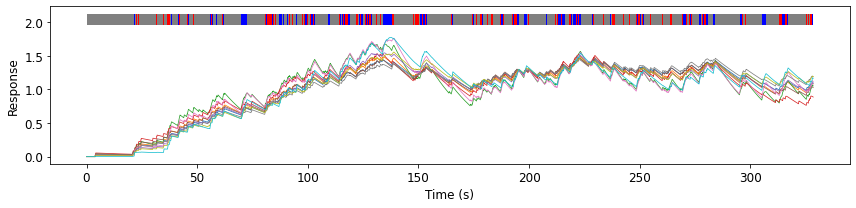

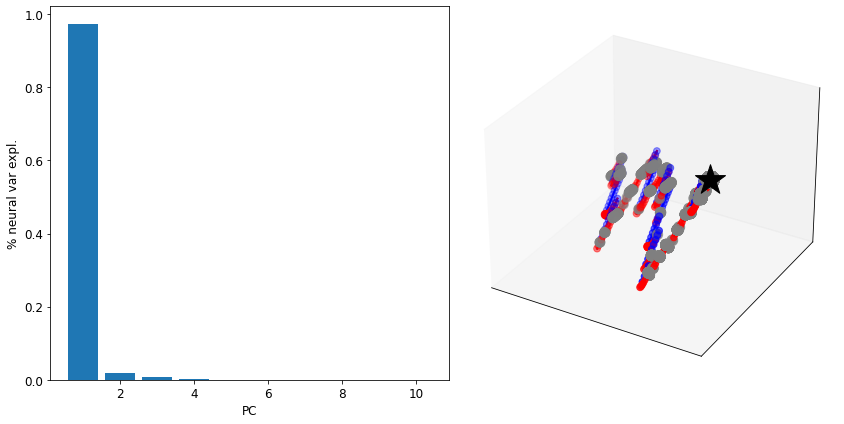

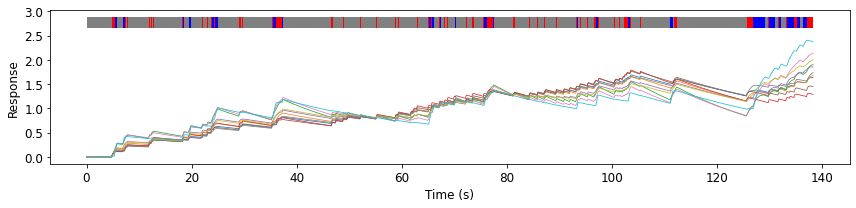

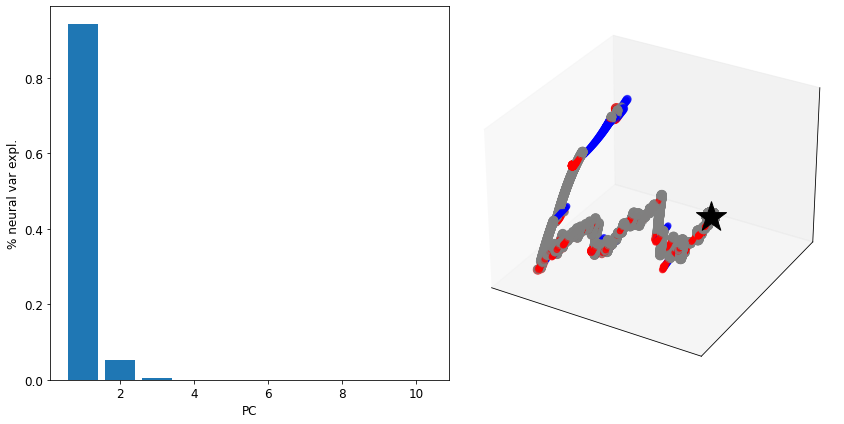

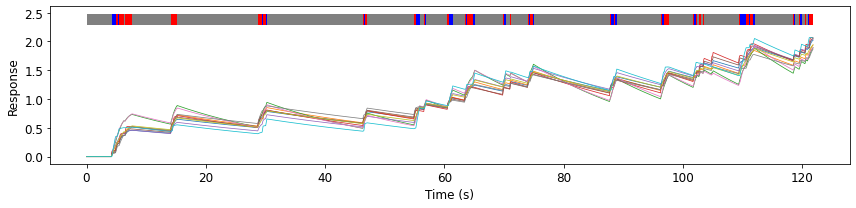

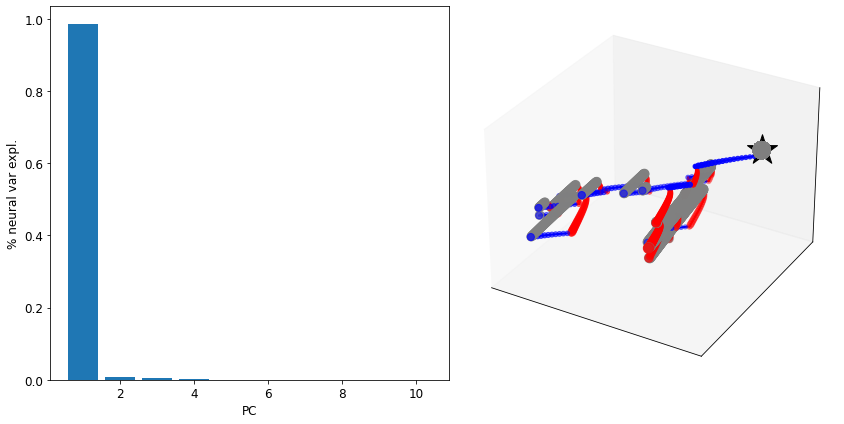

In [5]:
itrs_t_starts_t_ends = [
    (0, -2, 60),
    (6, -2, 200),
    (7, -2, 75),
]

for itr, t_start, t_end in itrs_t_starts_t_ends:
    df_tr = df_trs[itr]
    t = np.array(df_tr['T'])
    
    i_s = np.array(df_tr['S']).astype(float)
    i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)
    
    b = np.zeros(len(t), dtype=int)
    b[i_s == 1] = 1
    b[i_p == 1] = 2

    # simulate population response
    rs = smlt_ma(i_s, i_p, params, DT)
    for cnrn in range(N):
        rs[:, cnrn] /= np.mean(rs[:, cnrn])
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 3), tight_layout=True)
    
    # plot neural responses and song
    ax.plot(t, rs, lw=.75)
    plot_b(ax, t, b, [t[0], t[-1]+DT, 1.1*rs.max(), 1.2*rs.max()], c=['gray', 'b', 'r'])
    set_plot(ax, x_label='Time (s)', y_label='Response')
    
    fig.savefig(f'ms/fig_5_song_itr_{itr}.svg')
    
    # plot neural trajectory in PCA space
    pca = decomposition.PCA().fit(rs)
    rs_pc = pca.transform(rs)
    
    fig = plt.figure(figsize=(12, 6), tight_layout=True)
    axs = [fig.add_subplot(1, 2, 1), fig.add_subplot(1, 2, 2, projection='3d')]
    
    axs[0].bar(1 + np.arange(N), pca.explained_variance_ratio_)
    set_plot(axs[0], x_label='PC', y_label='% neural var expl.')
    
    
    mt = (t_start <= t) & (t < t_end)
    trj_3d(axs[1], t[mt], rs_pc[mt, 0], rs_pc[mt, 1], rs_pc[mt, 2], b[mt], s_max=300, v_max=2, gam=.1)
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[1].set_zticks([])
    axs[1].scatter(rs_pc[0, 0], rs_pc[0, 1], rs_pc[0, 2], marker='*', c='k', s=1000)
    set_plot(axs[1])
    
    fig.savefig(f'ms/fig_5_song_trj_itr_{itr}.svg')